In [76]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

def reformat_df(df):
    algs = []
    num_nodes = []
    sims = []
    edge_vars = []
    times = []
    costs = []
    for run in df.run_details.values:
        alg = run.split('_')[1]
        
        # rename algorithms
        if alg == 'heuristicEdgeId1':
            alg = 'HEID-1'
        elif alg == 'heuristicEdgeId2':
            alg = 'HEID-2'
        elif alg == 'heuristicMinCut1':
            alg = 'MCIP-H1'
        elif alg == 'heuristicMinCut2':
            alg = 'MCIP-H2'
        elif alg == 'Alg2':
            alg = 'MCIP-exact'
        elif alg == 'edgeIDbrute':
            alg = 'EDGEID-1'   
        elif alg == 'edgeIDbrutev2':
            alg = 'EDGEID'
        elif alg == 'edgeIDbrutev3':
            alg = 'EDGEID'
        elif alg == 'edgeIDbrutev3UB':
            alg = 'EDGEID'

            
        num_node = int(run.split('_')[4])
        sim = int(run.split('_')[6])
        edge_var = int(run.split('_')[-1])
        time = float(re.split(',|\(|\)', df[df.run_details == run]['runtime cost'].values[0])[1])
        cost = float(re.split(',|\(|\)', df[df.run_details == run]['runtime cost'].values[0])[2])

        algs.append(alg)
        num_nodes.append(num_node)
        sims.append(sim)
        edge_vars.append(edge_var)
        times.append(time)
        costs.append(cost)

    cols = ['algorithm', 'num_nodes', 'simulation', 'edge_weight_variant', 'time', 'cost']
    df_reformat = pd.DataFrame([algs, num_nodes, sims, edge_vars, times, costs]).T
    df_reformat.columns = cols
    return df_reformat


def get_av_se_times_costs(df, remove_dict):
    av_times = []
    se_times = []
    av_costs = []
    se_costs = []
    time_percents = []
    cost_percents = []
    
    for num_node in num_nodes:
        # get intersection of results for which all algorithms find a solution
        remove = remove_dict[num_node]
        a = df[(df.num_nodes == num_node)]
        all_sims = set(np.unique(a.simulation.values))
        to_keep = all_sims - remove
        b = a[a.simulation.isin(to_keep)]

        times = np.ma.masked_invalid(np.asarray(b[b.num_nodes == num_node]['time'].values, dtype=float))
        costs = np.ma.masked_invalid(np.asarray(b[b.num_nodes == num_node]['cost'].values, dtype=float))
        av_times.append(times.mean())
        se_times.append(times.std())
        av_costs.append(np.ma.masked_invalid(costs).mean())
        se_costs.append(costs.std())
        time_percents.append(np.percentile(times, [5, 95]))
        cost_percents.append(np.percentile(costs, [5, 95]))
    return av_times, se_times, av_costs, se_costs, time_percents, cost_percents

In [77]:
# FIRSTLY WE USE RESULTS FOR EDGEID WITH UPPERBOUND FROM HEID-1 and -2 ALROGITHMS

fn = 'all_results/no_sparsity_no_inf_EDGEID-UB/v3_all_noinfpen_nosparsity_rerun.csv'  # results of heuristic algorithms
fnv2 = 'all_results/no_sparsity_no_inf_EDGEID-UB/edgebrute3UB.csv'

df = pd.read_csv(fn)
dfv2 = pd.read_csv(fnv2)

df.columns = ['run_details', 'runtime cost']
dfv2.columns = ['run_details', 'runtime cost']
df = reformat_df(df)
dfv2 = reformat_df(dfv2)
# remove naivegreedy results (not required)
df = df[df.algorithm != 'NaiveGreedy']
df = df[df.algorithm != 'EDGEID-1']
df = pd.concat([df, dfv2])
df.reset_index(drop=True, inplace=True)

x_axis = 'Number of vertices before Y in topological order'
fs = 22

In [84]:
algorithms = ['HEID-1', 'HEID-2', 'MCIP-H1', 'MCIP-H2', 'MCIP-exact','EDGEID' ]

# get dictionary for which simulations failed to yield a solution on at least one algo,
# for each number of nodes. This can be used to find results for the intersection of results
# for which all algorithms found a solution

num_nodes_each = np.unique(df.num_nodes)

remove_dict = {}  
for num_nodes_ in num_nodes_each:
    
    d = df[df.num_nodes == num_nodes_]
    
    removes = []  # don't include EDGEID which fails a lot
    for algo in ['HEID-1', 'HEID-2', 'MCIP-H1', 'MCIP-H2']:
        # get list of simulations where costs is infinite
        rem = list((d[(d.algorithm==algo) & (d.cost == np.inf)].simulation.values))
        removes.extend(rem)
    removes = set(removes)
    
    remove_dict[num_nodes_] = removes
  
# if using the EDGEID with the heuristic upper bound, then we need to add the runtimes of HEID1 and 2
for num_node in num_nodes_each:
    all_sims = np.unique(df.simulation.values)
    for sim in all_sims:
        heid1_res = df[(df.algorithm == 'HEID-1') & (df.simulation == sim) & (df.num_nodes == num_node)].time.values       
        heid2_res = df[(df.algorithm == 'HEID-2') & (df.simulation == sim) & (df.num_nodes == num_node)].time.values
        edgeid = df[(df.algorithm == 'EDGEID') & (df.simulation == sim) & (df.num_nodes == num_node)].time.values
        res_sum = edgeid + heid1_res + heid2_res
        df['time'].loc[(df.algorithm == 'EDGEID') & (df.simulation == sim) & (df.num_nodes == num_node)] = res_sum


/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/ma/core.py:3375: UserWarning: Warning: converting a masked element to nan.
  _data[indx] = dval
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a

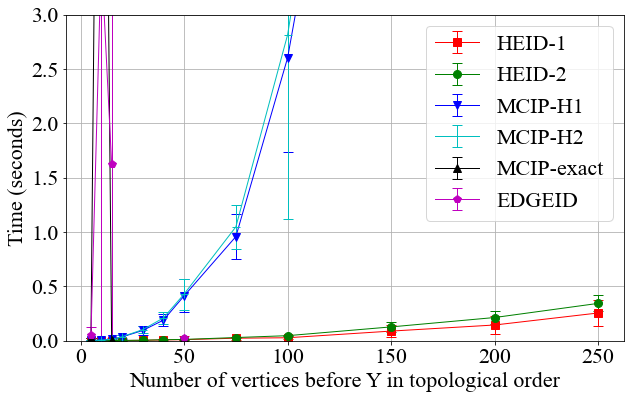

In [85]:
markers = ['s', 'o', 'v', '+', '^', 'p', 'X']
colors = ['r', 'g', 'b', 'c', 'k', 'm', 'darkorchid']
cp = 5
lw = 1
ms = 8
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': fs})

for i, algorithm in enumerate(algorithms):
        
    marker = markers[i]
    c = colors[i]
    data = df[df.algorithm == algorithm]
    num_nodes = np.unique(data.num_nodes)
    av_times, se_times, av_costs, se_costs, percent_times, percent_costs = get_av_se_times_costs(data, remove_dict)

    percent_times = 0 if algorithm == 'MCIP-exact' else se_times
    av_times = av_times[:-1] if algorithm == 'MCIP-exact' else av_times
    num_nodes = num_nodes[:-1] if algorithm == 'MCIP-exact' else num_nodes

    plt.errorbar(x=num_nodes, y=av_times, yerr=np.asarray(percent_times).T, linewidth=lw, markersize=ms, color=c, fmt=marker, capsize=cp, linestyle='-',
                 label=algorithm)

plt.xlabel(x_axis)
plt.ylabel('Time (seconds)')
# plt.yscale('log')
# plt.title('Runtimes')
plt.legend()
plt.ylim(0, 3)
plt.grid()
plt.savefig('all_results/times_noinf_zoomout.png', dpi=150)
plt.show()

/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/ma/core.py:3375: UserWarning: Warning: converting a masked element to nan.
  _data[indx] = dval
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a

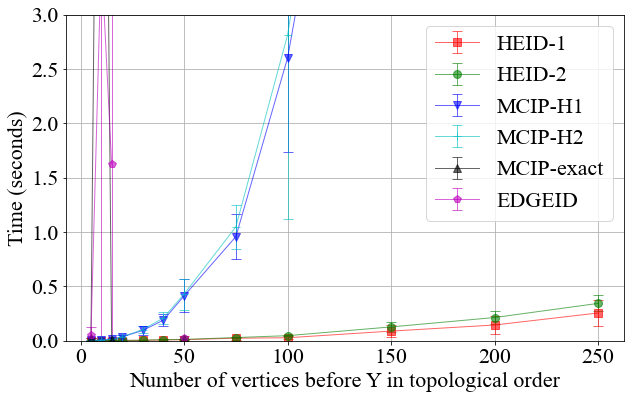

In [108]:
markers = ['s', 'o', 'v', '+', '^', 'p', 'X']
colors = ['r', 'g', 'b', 'c', 'k', 'm', 'darkorchid']
cp = 5
lw = 1
ms = 8
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': fs})
for i, algorithm in enumerate(algorithms):

    marker = markers[i]
    c = colors[i]
    data = df[df.algorithm == algorithm]
    num_nodes = np.unique(data.num_nodes)
    av_times, se_times, av_costs, se_costs, percent_times, percent_costs = get_av_se_times_costs(data, remove_dict)

    percent_times = 0 if algorithm == 'MCIP-exact' else se_times
    av_times = av_times[:-1] if algorithm == 'MCIP-exact' else av_times
    num_nodes = num_nodes[:-1] if algorithm == 'MCIP-exact' else num_nodes

    plt.errorbar(x=num_nodes, y=av_times, yerr=np.asarray(percent_times).T, alpha=0.6, linewidth=lw, markersize=ms, color=c, fmt=marker, capsize=cp, linestyle='-',
                 label=algorithm)

plt.xlabel(x_axis)
plt.ylabel('Time (seconds)')
# plt.yscale('log')
# plt.title('Runtimes')
plt.legend()
plt.ylim(0, 3)
plt.grid()
plt.savefig('all_results/times_noinf.png', dpi=150)
plt.show()

/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/ma/core.py:3375: UserWarning: Warning: converting a masked element to nan.
  _data[indx] = dval
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/matthewvowels/GitHub/PhD_part_1/anaconda3/envs/my-gpu-torch/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a

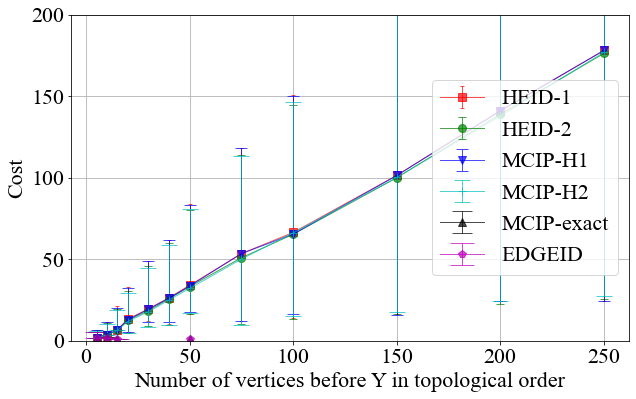

In [99]:
markers = ['s', 'o', 'v', '+', '^', 'p', 'X']
colors = ['r', 'g', 'b', 'c', 'k', 'm', 'darkorchid']
cps = [2, 4, 6, 8, 10, 12, 14]
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': fs})
for i, algorithm in enumerate(algorithms):
    cp = cps[i]
    ct = 1
    marker = markers[i]
    c = colors[i]
    data = df[df.algorithm == algorithm]
    num_nodes = np.unique(data.num_nodes)
    av_times, se_times, av_costs, se_costs, percent_times, percent_costs = get_av_se_times_costs(data, remove_dict)
    plt.errorbar(x=num_nodes, y=av_costs, linewidth=lw, alpha=0.7, markersize=ms, yerr=np.asarray(percent_costs).T, capthick=ct, color=c, fmt=marker, capsize=cp, linestyle='-',
                 label=algorithm)

plt.xlabel(x_axis)
plt.ylabel('Cost')
# plt.yscale('log')
plt.legend()
# plt.title('Costs')
plt.ylim(-0.03, 200)
plt.grid()
plt.savefig('all_results/costs_noinf.png', dpi=150)
plt.show()

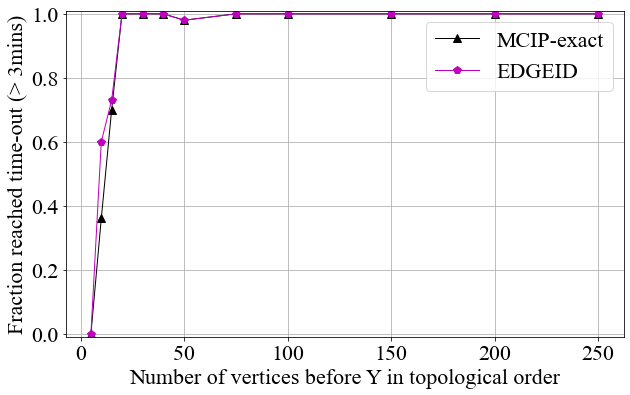

In [97]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': fs})
for i, algorithm in enumerate(algorithms):
    if 'H' not in algorithm:

        num_nodes_ = np.unique(df[df.algorithm == algorithm].num_nodes)

        percent_infs = []
        for num_node in num_nodes_:
            data = df[(df.num_nodes == num_node) & (df.algorithm == algorithm)]
            num_graphs = len(data)
            num_infs = ((data.cost == np.inf).sum())  # either because of time-out or because no solution found
            percent_infs.append(num_infs / num_graphs)

        marker = markers[i]
        c = colors[i]
        plt.errorbar(x=num_nodes_, y=percent_infs, color=c,linewidth=lw, markersize=ms, capsize=cp, fmt=marker, linestyle='-',
                     label=algorithm)

plt.xlabel(x_axis)
plt.ylabel('Fraction reached time-out (> 3mins)')
plt.ylim(-0.01, 1.01)
# plt.title('Fraction 3 minute timeouts')
plt.legend()
plt.grid()
plt.savefig('all_results/percent_failed_timeout_noinf.png', dpi=150)
plt.show()

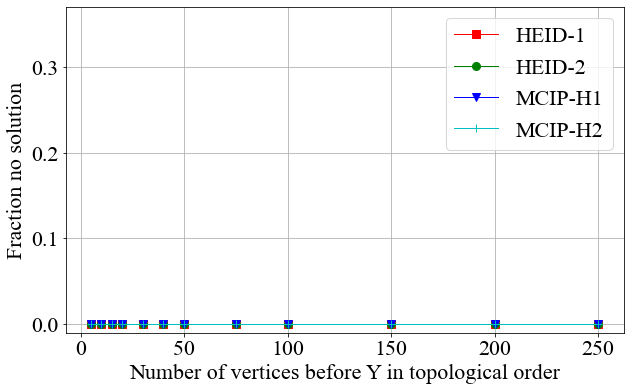

In [98]:
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': fs})
for i, algorithm in enumerate(algorithms):
    if 'H' in algorithm:

        num_nodes_ = np.unique(df[df.algorithm == algorithm].num_nodes)

        percent_infs = []
        for num_node in num_nodes_:
            data = df[(df.num_nodes == num_node) & (df.algorithm == algorithm)]
            num_graphs = len(data)
            num_infs = ((data.cost == np.inf).sum())  # either because of time-out or because no solution found
            percent_infs.append(num_infs / num_graphs)

        marker = markers[i]
        c = colors[i]
        plt.errorbar(x=num_nodes_, y=percent_infs, color=c,linewidth=lw, markersize=ms, capsize=cp, fmt=marker, linestyle='-',
                     label=algorithm)

plt.xlabel(x_axis)
plt.ylabel('Fraction no solution')
plt.ylim(-0.01, 0.37)
# plt.title('Fraction No Solution Found')
plt.legend()
plt.grid()
plt.savefig('all_results/percent_failed_no_solution_noinf.png', dpi=150)
plt.show()

In [67]:
# SECONDLY WE USE RESULTS FOR EDGEID <WITHOUT> UPPERBOUND FROM HEID-1 and -2 ALROGITHMS

fn = 'all_results/sparsity_no_inf_noUB/v3_all_noinfpen_sparsity_rerun.csv'  # results of heuristic algorithms

df = pd.read_csv(fn)

df.columns = ['run_details', 'runtime cost']

df = reformat_df(df)
# remove naivegreedy results (not required)
df = df[df.algorithm != 'NaiveGreedy']

df.reset_index(drop=True, inplace=True)

x_axis = 'Number of vertices before Y in topological order'
fs = 22

In [68]:
algorithms = ['HEID-1', 'HEID-2', 'MCIP-H1', 'MCIP-H2', 'MCIP-exact','EDGEID' ]

# get dictionary for which simulations failed to yield a solution on at least one algo,
# for each number of nodes. This can be used to find results for the intersection of results
# for which all algorithms found a solution

num_nodes_each = np.unique(df.num_nodes)

remove_dict = {}  
for num_nodes_ in num_nodes_each:
    
    d = df[df.num_nodes == num_nodes_]
    
    removes = []
    for algo in algorithms:
        # get list of simulations where costs is infinite
        rem = list((d[(d.algorithm==algo) & (d.cost == np.inf)].simulation.values))
        removes.extend(rem)
    removes = set(removes)
    
    remove_dict[num_nodes_] = removes

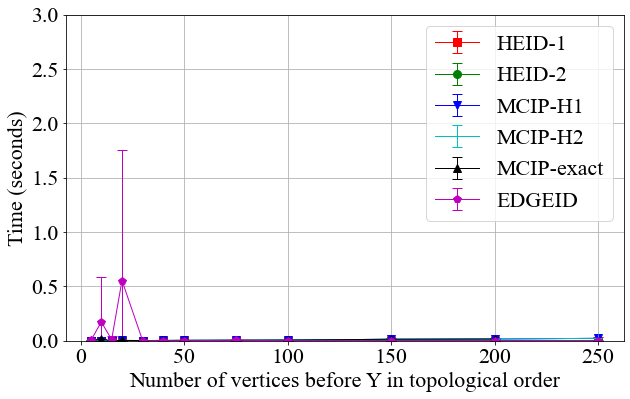

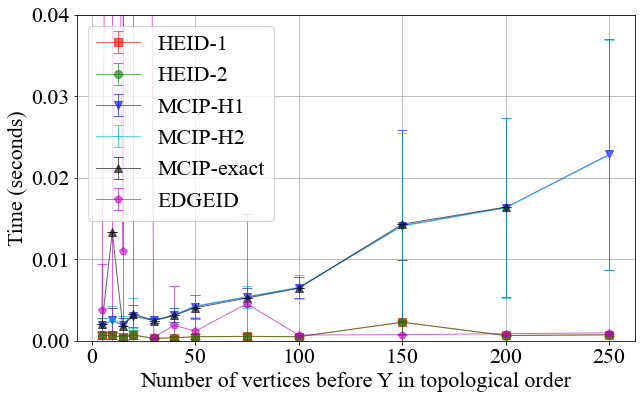

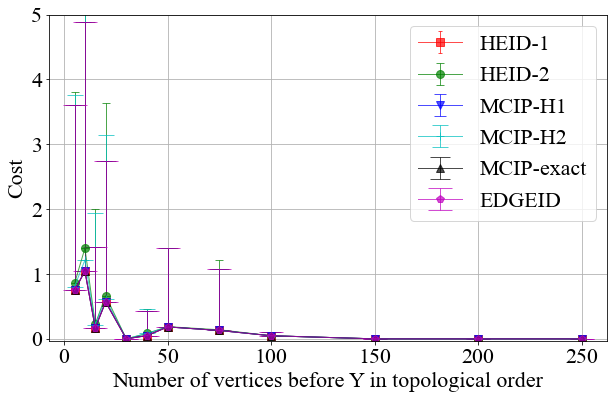

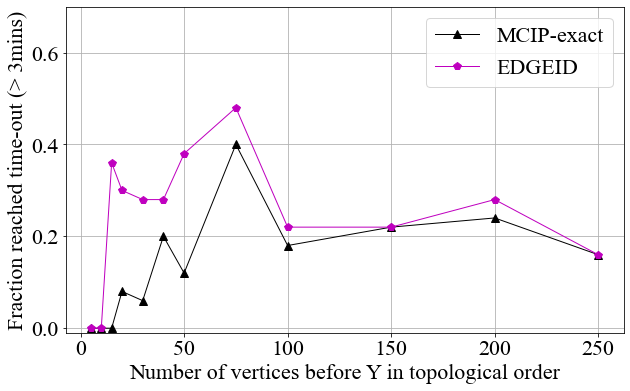

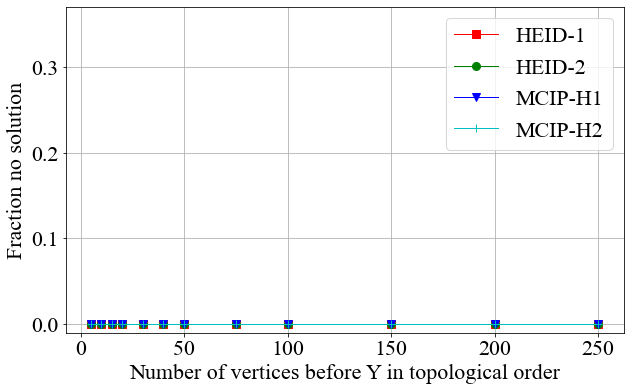

In [69]:
markers = ['s', 'o', 'v', '+', '^', 'p', 'X']
colors = ['r', 'g', 'b', 'c', 'k', 'm', 'darkorchid']
cp = 5
lw = 1
ms = 8
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': fs})

for i, algorithm in enumerate(algorithms):
        
    marker = markers[i]
    c = colors[i]
    data = df[df.algorithm == algorithm]
    num_nodes = np.unique(data.num_nodes)
    av_times, se_times, av_costs, se_costs, percent_times, percent_costs = get_av_se_times_costs(data, remove_dict)

    percent_times = 0 if algorithm == 'MCIP-exact' else se_times
    av_times = av_times[:-1] if algorithm == 'MCIP-exact' else av_times
    num_nodes = num_nodes[:-1] if algorithm == 'MCIP-exact' else num_nodes

    plt.errorbar(x=num_nodes, y=av_times, yerr=np.asarray(percent_times).T, linewidth=lw, markersize=ms, color=c, fmt=marker, capsize=cp, linestyle='-',
                 label=algorithm)

plt.xlabel(x_axis)
plt.ylabel('Time (seconds)')
# plt.yscale('log')
# plt.title('Runtimes')
plt.legend()
plt.ylim(0, 3)
plt.grid()
plt.savefig('all_results/times_noinf_zoomout.png', dpi=150)
plt.show()

markers = ['s', 'o', 'v', '+', '^', 'p', 'X']
colors = ['r', 'g', 'b', 'c', 'k', 'm', 'darkorchid']
cp = 5
lw = 1
ms = 8
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': fs})
for i, algorithm in enumerate(algorithms):

    marker = markers[i]
    c = colors[i]
    data = df[df.algorithm == algorithm]
    num_nodes = np.unique(data.num_nodes)
    av_times, se_times, av_costs, se_costs, percent_times, percent_costs = get_av_se_times_costs(data, remove_dict)

    percent_times = 0 if algorithm == 'MCIP-exact' else se_times
    av_times = av_times[:-1] if algorithm == 'MCIP-exact' else av_times
    num_nodes = num_nodes[:-1] if algorithm == 'MCIP-exact' else num_nodes

    plt.errorbar(x=num_nodes, y=av_times, yerr=np.asarray(percent_times).T, alpha=0.6, linewidth=lw, markersize=ms, color=c, fmt=marker, capsize=cp, linestyle='-',
                 label=algorithm)

plt.xlabel(x_axis)
plt.ylabel('Time (seconds)')
# plt.yscale('log')
# plt.title('Runtimes')
plt.legend()
plt.ylim(0, 0.04)
plt.grid()
plt.savefig('all_results/times_noinf.png', dpi=150)
plt.show()

markers = ['s', 'o', 'v', '+', '^', 'p', 'X']
colors = ['r', 'g', 'b', 'c', 'k', 'm', 'darkorchid']
cps = [2, 4, 6, 8, 10, 12, 14]
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': fs})
for i, algorithm in enumerate(algorithms):
    cp = cps[i]
    ct = 1
    marker = markers[i]
    c = colors[i]
    data = df[df.algorithm == algorithm]
    num_nodes = np.unique(data.num_nodes)
    av_times, se_times, av_costs, se_costs, percent_times, percent_costs = get_av_se_times_costs(data, remove_dict)
    plt.errorbar(x=num_nodes, y=av_costs, linewidth=lw, alpha=0.7, markersize=ms, yerr=np.asarray(percent_costs).T, capthick=ct, color=c, fmt=marker, capsize=cp, linestyle='-',
                 label=algorithm)

plt.xlabel(x_axis)
plt.ylabel('Cost')
# plt.yscale('log')
plt.legend()
# plt.title('Costs')
plt.ylim(-0.03, 5)
plt.grid()
plt.savefig('all_results/costs_noinf.png', dpi=150)
plt.show()

plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': fs})
for i, algorithm in enumerate(algorithms):
    if 'H' not in algorithm:

        num_nodes_ = np.unique(df[df.algorithm == algorithm].num_nodes)

        percent_infs = []
        for num_node in num_nodes_:
            data = df[(df.num_nodes == num_node) & (df.algorithm == algorithm)]
            num_graphs = len(data)
            num_infs = ((data.cost == np.inf).sum())  # either because of time-out or because no solution found
            percent_infs.append(num_infs / num_graphs)

        marker = markers[i]
        c = colors[i]
        plt.errorbar(x=num_nodes_, y=percent_infs, color=c,linewidth=lw, markersize=ms, capsize=cp, fmt=marker, linestyle='-',
                     label=algorithm)

plt.xlabel(x_axis)
plt.ylabel('Fraction reached time-out (> 3mins)')
plt.ylim(-0.01, 0.7)
# plt.title('Fraction 3 minute timeouts')
plt.legend()
plt.grid()
plt.savefig('all_results/percent_failed_timeout_noinf.png', dpi=150)
plt.show()

plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': fs})
for i, algorithm in enumerate(algorithms):
    if 'H' in algorithm:

        num_nodes_ = np.unique(df[df.algorithm == algorithm].num_nodes)

        percent_infs = []
        for num_node in num_nodes_:
            data = df[(df.num_nodes == num_node) & (df.algorithm == algorithm)]
            num_graphs = len(data)
            num_infs = ((data.cost == np.inf).sum())  # either because of time-out or because no solution found
            percent_infs.append(num_infs / num_graphs)

        marker = markers[i]
        c = colors[i]
        plt.errorbar(x=num_nodes_, y=percent_infs, color=c,linewidth=lw, markersize=ms, capsize=cp, fmt=marker, linestyle='-',
                     label=algorithm)

plt.xlabel(x_axis)
plt.ylabel('Fraction no solution')
plt.ylim(-0.01, 0.37)
# plt.title('Fraction No Solution Found')
plt.legend()
plt.grid()
plt.savefig('all_results/percent_failed_no_solution_noinf.png', dpi=150)
plt.show()

In [80]:
b

,algorithm,num_nodes,simulation,edge_weight_variant,time,cost
